In [1]:
import torch
import time
import random
import argparse
import math
import os
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from scipy import stats
from tqdm import tqdm
from collections import OrderedDict
from torchsummary import summary
from torch.backends import cudnn
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from torch.utils.tensorboard import SummaryWriter
import pickle
import scipy.io

from google.colab import drive
import sys
drive.mount("/content/drive", force_remount=True)

main_path = '/content/drive/My Drive/PINN/' # ENZE marked: you need to change your main_path if it's not here
sys.path.append(main_path)
from cyclic_lr_scheduler import CyclicLR
from utils import draw_two_dimension, draw_two_dimension_different_x

Mounted at /content/drive


In [4]:
class ConfigAD:
   def __init__(self):
        # print("--------------------------------------------------call init--------------------------------------------------")
       
        self.T_all = 10.0
        self.T = 10.0 # collocation point?
        self.T_unit = 0.05
        self.T_N = int(self.T / self.T_unit)
        self.N = int(self.T / self.T_unit)

        self.Node = 40

        # parameters
        # Amyloid
        self.k_a = nn.Parameter(torch.abs(torch.randn(1)))  # 2.1
        self.k_ta = 0.08
        self.k_mt = 0.718
        self.d_a = 0.06
        self.theta = 2
        # Tau
        self.k_t = 5
        self.k_at = 0.08
        self.k_ma = 0.7
        self.d_t = 0.06
        self.delta = 2
        # Neurodegeneration
        self.k_tn = 0.03566
        self.k_mtn = 0.08
        self.gamma = 3
        self.k_an = 0.05
        self.k_man = 5.022
        self.beta = 3
        self.k_atn = 0.03
        # Cognition
        self.k_r = 0.0846
        self.k_nc = 0.3596
        self.k_mn = 1.8944
        self.alpha = 2

        np.random.seed(0)

        self.ub = self.T
        self.lb = 0.0

        self.only_truth_flag = False  # True means only using loss_1 for truth_rate = 1.00, no other loss
        self.truth_rate = 1 #0.0034 # 0.0034 * 300 = 1 point(s) as truth #1.00 #0.25 #0.0005
        self.truth_length = int(self.truth_rate * self.T / self.T_unit)
        if not self.only_truth_flag:
            print("self.truth_length: {} of {} all ".format(self.truth_length, self.T_N))

        self.continue_period = 0.2
        self.round_bit = 3
        self.continue_id = None
        self.mapping_overall_flag = False
        self.loss2_partial_flag = False


In [ ]:
torch.abs(torch.randn(1))

tensor([0.0660])

In [5]:
def block_design_a(network_unit, sig):
    # print("--------------------------------------------------call block design a--------------------------------------------------")
    return nn.Sequential((OrderedDict({
      'lin1': nn.Linear(1, network_unit),
      'sig1': sig,
      'lin2': nn.Linear(network_unit, network_unit),
      'sig2': sig,
      'lin3': nn.Linear(network_unit, network_unit),
      'sig3': sig,
      'lin4': nn.Linear(network_unit, 1),
    })))

In [3]:
class SimpleNetworkAD(nn.Module):
  def __init__(self, config):
        # print("--------------------------------------------------call init of SimpleNetwork AD--------------------------------------------------")
        super(SimpleNetworkAD, self).__init__()
        self.setup_seed(0)
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.x, self.y0, self.t0 = None, None, None
        self.generate_x()
        # self.optimizer = optim.LBFGS(self.parameters(), lr=0.001, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100, line_search_fn=None)
        self.initial_start()
        self.model_name = "SimpleNetworkAD"
        self.gt = GroundTruthAD(self.config.T, self.config.T_N)
        self.gt_data = torch.Tensor(self.gt.data).to(self.device)
        # self.gt_v = torch.Tensor(self.gt.v).to(self.device)
        self.kkk = nn.Parameter(torch.abs(torch.randn(1)))  # 2.1
        self.k1 = nn.Parameter(torch.abs(torch.randn(1)))  
        self.k2 = nn.Parameter(torch.abs(torch.randn(1)))
        self.k3 = nn.Parameter(torch.abs(torch.randn(1)))
        self.k4 = nn.Parameter(torch.abs(torch.randn(1)))
        self.k5 = nn.Parameter(torch.abs(torch.randn(1)))

        self.sig = nn.Tanh()
        self.network_unit = 20

        # Design A
        A_blocks = [block_design_a(self.network_unit, self.sig) for i in range(self.config.Node//4)]
        T_blocks = [block_design_a(self.network_unit, self.sig) for i in range(self.config.Node//4)]
        N_blocks = [block_design_a(self.network_unit, self.sig) for i in range(self.config.Node//4)]
        C_blocks = [block_design_a(self.network_unit, self.sig) for i in range(self.config.Node//4)]

        self.sequences_A = nn.Sequential(*A_blocks)
        self.sequences_T = nn.Sequential(*T_blocks)
        self.sequences_N = nn.Sequential(*N_blocks)
        self.sequences_C = nn.Sequential(*C_blocks)


  def forward(self, inputs):
      # print("--------------------------------------------------call forward--------------------------------------------------")

      A_input = inputs[:, 0:10]
      T_input = inputs[:, 10:20]
      N_input = inputs[:, 20:30]
      C_input = inputs[:, 30:40]
      
      A_output = [] 
      T_output = []
      N_output = [] 
      C_output = []

    
      # Design A  
      for i in range(self.config.Node//4):
        A_output.append(self.sequences_A[i](A_input[:,i:i+1]))
        T_output.append(self.sequences_T[i](T_input[:,i:i+1]))
        N_output.append(self.sequences_N[i](N_input[:,i:i+1]))
        C_output.append(self.sequences_C[i](C_input[:,i:i+1]))

      A_output = torch.cat(tuple(item for item in A_output), 1)
      T_output = torch.cat(tuple(item for item in T_output), 1)
      N_output = torch.cat(tuple(item for item in N_output), 1)
      C_output = torch.cat(tuple(item for item in C_output), 1)


      outputs = torch.cat((A_output, T_output, N_output, C_output), 1)
      return outputs
  
  def generate_x(self):
      # print("--------------------------------------------------call generate x--------------------------------------------------")
      x = [[i*self.config.T_unit for j in range(self.config.Node)] for i in range(self.config.N)]  # toy
      x = np.asarray(x)
      x = self.encode_t(x)
      print("continue_id = {}: [0, {}] is mapped to [{}, {}]".format(self.config.continue_id, self.config.T, len(x[0]), len(x[-1])))
      self.x = torch.Tensor(x).float().to(self.device)
      



  def initial_start(self):
    
      mat = scipy.io.loadmat(main_path+'Data/20220923YOUT.mat')
      self.t0 = torch.Tensor(np.asarray(np.asarray([np.random.rand()] * (self.config.Node)).reshape([1, -1]))).float().to(self.device)#
      self.y0 = torch.Tensor(mat['YOUT'][0,:]).reshape([1, -1]).float().to(self.device)

      print("self.y0",self.y0.shape)


  def encode_t(self, num):
    return num / self.config.T_all * 2.0 

  def decode_t(self, num):
      return (num ) / 2.0 * self.config.T_all

  def loss_only_ground_truth(self):
    # print("--------------------------------------------------call loss only ground truth--------------------------------------------------")
    self.eval()
    y = self.forward(self.x)
    self.loss_norm = torch.nn.MSELoss().to(self.device)
    # print(y.shape, self.gt_data.shape)
    loss = self.loss_norm(y, self.gt_data)


    A = y[:, 0:10]
    T = y[:, 10:20]
    N = y[:, 20:30]
    C = y[:, 30:40]


    A_t_collection, T_t_collection, N_t_collection, C_t_collection = [], [], [], []

    for ii in range(self.config.Node//4):
      A_t_collection.append(torch.gradient(A[:,ii:ii+1].reshape([self.config.T_N]), spacing=(self.encode_t(self.x)[:, 0:1].reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1]))  # u_t = y_t[:, 0:1]
      T_t_collection.append(torch.gradient(T[:,ii:ii+1].reshape([self.config.T_N]), spacing=(self.encode_t(self.x)[:, 0:1].reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1]))  # u_t = y_t[:, 0:1]
      N_t_collection.append(torch.gradient(N[:,ii:ii+1].reshape([self.config.T_N]), spacing=(self.encode_t(self.x)[:, 0:1].reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1]))  # u_t = y_t[:, 0:1]
      C_t_collection.append(torch.gradient(C[:,ii:ii+1].reshape([self.config.T_N]), spacing=(self.encode_t(self.x)[:, 0:1].reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1]))  # u_t = y_t[:, 0:1]

    A_t = torch.cat(A_t_collection, 1)
    T_t = torch.cat(T_t_collection, 1)
    N_t = torch.cat(N_t_collection, 1)
    C_t = torch.cat(C_t_collection, 1) 


    
    mat = scipy.io.loadmat(main_path+'Data/20220822truth40.mat')
    Laplacian = torch.Tensor(mat['avgNet']).float().to(self.device)[0:10, 0:10]
    resil = scipy.io.loadmat(main_path+'Data/20220822truth40.mat')
    r = torch.Tensor(resil['r']).float().to(self.device).reshape([10])

    # f_a = A_t - (self.k1*A*(1 - A) + (self.config.k_ta*torch.pow(T,self.config.theta)) / (np.power((self.config.k_mt),self.config.theta) + torch.pow(T,self.config.theta)) - self.config.d_a*torch.matmul(A,Laplacian))
 
    # f_t = T_t - (self.config.k_t*T*(1 - T) + (self.config.k_at*torch.pow(A,self.config.delta)) / (np.power((self.config.k_ma),self.config.delta) + torch.pow(A,self.config.delta)) - self.config.d_t*torch.matmul(T,Laplacian))
    # f_n = N_t - ((self.config.k_tn*torch.pow(T,self.config.gamma)) / (np.power((self.config.k_mtn),self.config.gamma) + torch.pow(T,self.config.gamma))+ 
    #              (self.config.k_an*torch.pow(A,self.config.beta)) / (np.power((self.config.k_man),self.config.beta) + torch.pow(A,self.config.beta))+ 
    #              self.config.k_atn*A*T)
    # f_c = C_t - (- self.config.k_r*r + (self.config.k_nc*torch.pow(N,self.config.alpha)) / (np.power((self.config.k_mn),self.config.alpha) + torch.pow(N,self.config.alpha)))
   

    # f_a = A_t - (self.k1*A*(1 - A) + (self.config.k_ta*torch.pow(T,self.config.theta)) / (np.power((self.config.k_mt),self.config.theta) + torch.pow(T,self.config.theta)) - self.config.d_a*torch.matmul(A,Laplacian))
 
    # f_t = T_t - (self.config.k_t*T*(1 - T) + (self.config.k_at*torch.pow(A,self.config.delta)) / (np.power((self.config.k_ma),self.config.delta) + torch.pow(A,self.config.delta)) - self.config.d_t*torch.matmul(T,Laplacian))
    # f_n = N_t - ((self.config.k_tn*torch.pow(T,self.config.gamma)) / (np.power((self.config.k_mtn),self.config.gamma) + torch.pow(T,self.config.gamma))+ 
    #              (self.config.k_an*torch.pow(A,self.config.beta)) / (np.power((self.config.k_man),self.config.beta) + torch.pow(A,self.config.beta))+ 
    #              self.config.k_atn*A*T)
    # f_c = C_t - (- self.config.k_r*r + (self.config.k_nc*torch.pow(N,self.config.alpha)) / (np.power((self.config.k_mn),self.config.alpha) + torch.pow(N,self.config.alpha)))
   

    f_y = torch.cat((f_a, f_t, f_n, f_c), 1)
    zeros_2 = torch.Tensor([[0.0 for i in range(self.config.Node//4 )] for j in range( self.config.N )]).to(self.device)
    zeros_2D = torch.Tensor([[0.0 for i in range(self.config.Node )] for j in range( self.config.N )]).to(self.device)
    
    loss_2 = self.loss_norm(f_y, zeros_2D)  # + torch.var(torch.square(f_y))


    self.train()



    return loss, [loss, loss_2], []
  

  def loss(self):
    self.eval()
    y = self.forward(self.x)

    y0_pred = self.forward(self.t0)

    A = y[:, 0:10]
    T = y[:, 10:20]
    N = y[:, 20:30]
    C = y[:, 30:40]

    A_t_collection, T_t_collection, N_t_collection, C_t_collection = [], [], [], []

    for ii in range(self.config.Node//4):
      A_t_collection.append(torch.gradient(A[:,ii:ii+1].reshape([self.config.T_N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1]))  # u_t = y_t[:, 0:1]
      T_t_collection.append(torch.gradient(T[:,ii:ii+1].reshape([self.config.T_N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1]))  # u_t = y_t[:, 0:1]
      N_t_collection.append(torch.gradient(N[:,ii:ii+1].reshape([self.config.T_N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1]))  # u_t = y_t[:, 0:1]
      C_t_collection.append(torch.gradient(C[:,ii:ii+1].reshape([self.config.T_N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1]))  # u_t = y_t[:, 0:1]


    A_t = torch.cat(A_t_collection, 1)
    T_t = torch.cat(T_t_collection, 1)
    N_t = torch.cat(N_t_collection, 1)
    C_t = torch.cat(C_t_collection, 1) 
    

    mat = scipy.io.loadmat(main_path+'Data/20220724truth40.mat')
    Laplacian = torch.Tensor(mat['avgNet']).float().to(self.device)[0:10, 0:10]
    resil = scipy.io.loadmat(main_path+'Data/20220724truth40.mat')
    r = torch.Tensor(resil['r']).float().to(self.device).reshape([10])
    
    f_a = A_t - (self.k1*A*(1 - A) + (self.config.k_ta*torch.pow(T,self.config.theta)) / (np.power((self.config.k_mt),self.config.theta) + torch.pow(T,self.config.theta)) - self.config.d_a*torch.matmul(A,Laplacian))
    f_t = T_t - (self.k2*T*(1 - T) + (self.config.k_at*torch.pow(A,self.config.delta)) / (np.power((self.config.k_ma),self.config.delta) + torch.pow(A,self.config.delta)) - self.config.d_t*torch.matmul(T,Laplacian))
    f_n = N_t - ((self.k3*torch.pow(T,self.config.gamma)) / (np.power((self.config.k_mtn),self.config.gamma) + torch.pow(T,self.config.gamma))+ 
                 (self.k4*torch.pow(A,self.config.beta)) / (np.power((self.config.k_man),self.config.beta) + torch.pow(A,self.config.beta))+ 
                 self.k5*A*T)
    f_c = C_t - (- self.config.k_r*r + (self.config.k_nc*torch.pow(N,self.config.alpha)) / (np.power((self.config.k_mn),self.config.alpha) + torch.pow(N,self.config.alpha)))
    f_y = torch.cat((f_a, f_t, f_n, f_c), 1)
  

    # print("--------------------------------------------------calculate gradient--------------------------------------------------")

    # L2 norm
    self.loss_norm = torch.nn.MSELoss().to(self.device)
    zeros_1D = torch.Tensor([[0.0]] * self.config.N).to(self.device)

    zeros_2D = torch.Tensor([[0.0 for i in range(self.config.Node )] for j in range( self.config.N )]).to(self.device)

    loss_1 = self.loss_norm(y[:self.config.truth_length, :], self.gt_data[:self.config.truth_length, 0:40])*1e3

    
    
    if self.config.loss2_partial_flag:
        new_period = int(self.config.continue_period * self.config.T_all / self.config.T_unit)
        loss_2 = self.loss_norm(f_y[-new_period:, :], zeros_2D[-new_period:, :])
    else:
        loss_2 = self.loss_norm(f_y, zeros_2D)  # + torch.var(torch.square(f_y))
        # print(5)



    loss_3 = self.loss_norm(torch.abs(y[:self.config.truth_length, :]-0.3), y[:self.config.truth_length, :]-0.3)*1e5

    loss = (loss_1 + loss_2 + loss_3) # + loss_3)#+ loss_4 + loss_5) / 1e5
    
    self.train()
    return loss, [loss_1, loss_2, loss_3], []
    # return torch.mean(torch.square(y_hat - y))
    # return F.mse_loss(torch.cat((u_hat, v_hat), 1), torch.cat((u, v), 1))
    # return torch.abs(u_hat - u) + torch.abs(v_hat - v)  # F.mse_loss(x_hat, x) + beta * self.kl_div(rho)
  
  @staticmethod
  def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True
  

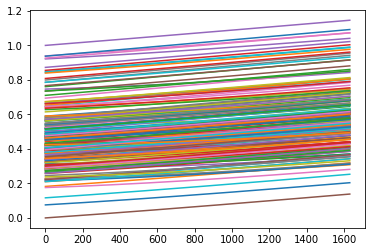

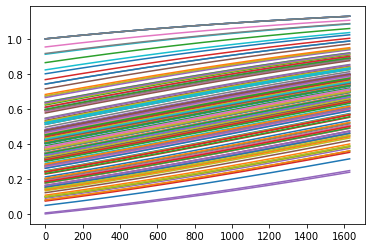

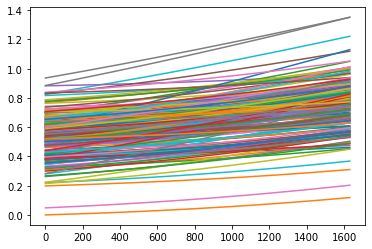

In [25]:
mat = scipy.io.loadmat(main_path+'Data/20220822truth40.mat')

mat = scipy.io.loadmat(main_path+'Data/20220923YOUT.mat')
# self.t0 = torch.Tensor(np.asarray(np.asarray([np.random.rand()] * (self.config.Node)).reshape([1, -1]))).float().to(self.device)#
# self.y0 = torch.Tensor(mat['YOUT'][0,:]).reshape([1, -1]).float().to(self.device)
x = torch.Tensor(mat['pred']).float()

for i in range(x.size()[0]):
  plt.plot(x[i, :,0])
plt.show()


for i in range(x.size()[0]):
  plt.plot(x[i, :,1])
plt.show()


for i in range(x.size()[0]):
  plt.plot(x[i, :,2])
plt.show()


In [7]:
class GroundTruthAD:
  def __init__(self, t_max, length):
    mat = scipy.io.loadmat(main_path+'Data/20220822truth40.mat')
    self.data = torch.Tensor(mat['YOUT'][1:,:].reshape(200,-1)).float()
    print("----------------------------- ground truth ------------------------------------")

    plt.plot(self.data[:,0:10], 'b')
    plt.plot(self.data[:,10:20], 'g')
    plt.plot(self.data[:,20:30], 'y')
    plt.plot(self.data[:,30:40], 'c')
    plt.show()

    print("--------------------------------------------------------------------------")


def get_now_string():
    return time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime(time.time()))


In [8]:
def train_ad(model, args, config, now_string):
    # print("--------------------------------------------------call train AD--------------------------------------------------")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    model.train()
    model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_last.pt"
    model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_best.pt"
    loss_save_path = f"{args.main_path}/loss/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_loss_{args.epoch}.npy"
    board_save_path = f"{args.main_path}/board/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_board"
    print("using " + str(device))
    print("epoch = {}".format(args.epoch))
    print("epoch_step = {}".format(args.epoch_step))
    print("model_name = {}".format(model.model_name))
    print("now_string = {}".format(now_string))
    print("model_save_path_last = {}".format(model_save_path_last))
    print("model_save_path_best = {}".format(model_save_path_best))
    print("loss_save_path = {}".format(loss_save_path))
    print("args = {}".format({item[0]: item[1] for item in args.__dict__.items() if item[0][0] != "_"}))
    print("config = {}".format({item[0]: item[1] for item in config.__dict__.items() if item[0][0] != "_"}))
    print("ONLY TRUTH FLAG: ", )
    # gt = GroundTruthPP(config.T, config.N)
    writer = SummaryWriter(board_save_path)

    # optimizer = optim.Adam(model.parameters(), lr=args.lr)
    initial_lr = args.lr
    optimizer = optim.Adam(model.parameters(), lr = initial_lr)

    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch/10000+1)) # decade
    # scheduler = CyclicLR(optimizer, base_lr=0.001, max_lr=0.01, step_size=10000) # cyclic
    epoch_step = args.epoch_step
    start_time = time.time()
    start_time_0 = start_time
    best_loss = 999999
    now_time = 0
    loss_record = []
    param_ka = []
    
    for epoch in range(1, args.epoch + 1):
        # print("in epoch ", epoch)
        optimizer.zero_grad()
        inputs = model.x
        outputs = model(inputs)
        if config.only_truth_flag:
          # print("--------------------------------------------------loss only ground truth--------------------------------------------------")
          loss, loss_list, _ = model.loss_only_ground_truth()
        else:
          # print("--------------------------------------------------normal loss--------------------------------------------------")
          loss, loss_list, _ = model.loss()
        writer.add_scalar('Loss/train', loss.item(), epoch)
        
        # loss_1, loss_2, loss_3 = loss_list[0], loss_list[1], loss_list[2]
        loss.backward()
        # print("loss backward")
        # options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}
        # _loss, _, lr, _, F_eval, G_eval, _, _ = optimizer.step(closure)
        optimizer.step()
        scheduler.step()
        loss_record.append(float(loss.item()))
        param_ka.append(float(model.k5.item()))
        if epoch % epoch_step == 0:
            now_time = time.time()
            loss_print_part = " ".join(["Loss_{0:d}:{1:.6f}".format(i + 1, loss_part.item()) for i, loss_part in enumerate(loss_list)])
            # print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Loss_3: {5:.6f} Lr:{6:.6f} Time:{7:.6f}s ({8:.2f}min in total)".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), optimizer.param_groups[0]["lr"], now_time - start_time, (now_time - start_time_0) / 60.0))
            print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} {3} Lr:{4:.6f} Time:{5:.6f}s ({6:.2f}min in total, {7:.2f}min remains)".format(epoch, args.epoch, loss.item(), loss_print_part, optimizer.param_groups[0]["lr"], now_time - start_time, (now_time - start_time_0) / 60.0, (now_time - start_time_0) / 60.0 / epoch * (args.epoch - epoch)))
            print("True: 2.1; estimated: ", model.k1.item())
            print("True: 5; estimated: ", model.k2.item())
            print("True: 0.03566; estimated: ", model.k3.item())
            print("True: 0.05; estimated: ", model.k4.item())
            print("True: 0.03; estimated: ", model.k5.item())
            print("----------------------------")
            start_time = time.time()
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_last)
            # print(inputs.shape)
            if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(
                    {
                        'epoch': args.epoch,
                        'model_state_dict': model.state_dict(),
                        # 'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss.item()
                    }, model_save_path_best)
        if epoch % args.save_step == 0:
            test_ad(model, args, config, now_string,param_ka, True, model.gt, None)

            # np.save(loss_save_path, np.asarray(loss_record))
    
    num_parameter = -1  # get_model_parameters(model, config)
    best_loss = best_loss
    time_cost = (now_time - start_time_0) / 60.0
    loss_record = np.asarray(loss_record)
    np.save(loss_save_path, loss_record)
    # draw_loss(loss_record)
    print("tensor board path: {}".format(board_save_path))
    print("%load_ext tensorboard")
    print("%tensorboard --logdir={}".format(board_save_path.replace(" ", "\ ")))
    # return [num_parameter, best_loss, time_cost, loss_record]
    return model


def draw_loss(loss_list):
    map = np.asarray([[loss] for loss in loss_list])
    plt.plot(map)
    plt.show()
    plt.clf()

In [9]:
def test_ad(model, args, config, now_string, param_ka ,show_flag=True, gt=None, loss_2_details=None):
    # print("--------------------------------------------------call test ad--------------------------------------------------")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    # model_save_path = f"{args.main_path}train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_last.pt"
    # model.load_state_dict(torch.load(model_save_path, map_location=device)["model_state_dict"])
    model.eval()
    print("Testing & drawing...")
    t = model.x
    y = model(t)
    y0_pred = model(model.t0)
   
    x = [item[0] for item in model.decode_t(t).cpu().detach().numpy()]
   
    plt.figure(figsize=(16,6))
    ax1 = plt.subplot(1, 2, 1)
    
    
    ax1.plot(x, y.cpu().detach().numpy()[:,0:10], 'b')
    ax1.plot(x, y.cpu().detach().numpy()[:,10:20], 'g')
    ax1.plot(x, y.cpu().detach().numpy()[:,20:30], 'y')
    ax1.plot(x, y.cpu().detach().numpy()[:,30:40], 'c')
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(np.asarray(param_ka))

    plt.show()
    plt.close()
   
   

In [ ]:
# test_ad(model, args, self.config, now_string=get_now_string())

In [10]:
class Args:
    epoch = 50000
    epoch_step = 10000
    lr = 0.003
    main_path = "."
    save_step = 10000

class TestArgs:
    epoch = 1
    epoch_step = 1
    lr = 0.03
    main_path = "."
    save_step = 1


def run_ad_truth(main_path=None):
    # print("--------------------------------------------------call run ad truth--------------------------------------------------")
    args = Args
    if main_path:
        args.main_path = main_path
    if not os.path.exists("{}/train".format(args.main_path)):
        os.makedirs("{}/train".format(args.main_path))
    if not os.path.exists("{}/figure".format(args.main_path)):
        os.makedirs("{}/figure".format(args.main_path))
    if not os.path.exists("{}/loss".format(args.main_path)):
        os.makedirs("{}/loss".format(args.main_path))
    now_string = get_now_string()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    config = ConfigAD()
    model = SimpleNetworkAD(config).to(device)
    model = train_ad(model, args, config, now_string)
    
    print("weight1:", model.config.k_a.cpu().detach().numpy().flatten())

    print("----------------------------truth-----------------------------------------")
    print("--------------------------------------------------------------------------")

    mat = scipy.io.loadmat(main_path+'Data/20220822truth40.mat')
    x = torch.Tensor(mat['YOUT']).float()
    plt.plot(x[:,0:10], 'b')
    plt.plot(x[:,10:20], 'g')
    plt.plot(x[:,20:30], 'y')
    plt.plot(x[:,30:40], 'c')
    plt.show()

    return model


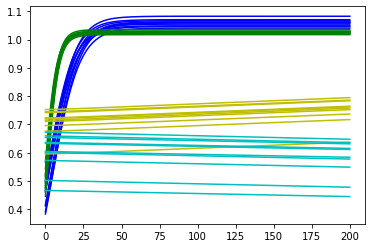

In [11]:
mat = scipy.io.loadmat(main_path+'Data/20220822truth40.mat')
x = torch.Tensor(mat['YOUT']).float()
plt.plot(x[:,0:10], 'b')
plt.plot(x[:,10:20], 'g')
plt.plot(x[:,20:30], 'y')
plt.plot(x[:,30:40], 'c')
plt.show()

In [ ]:
x.shape

torch.Size([40])

self.truth_length: 200 of 200 all 
continue_id = None: [0, 10.0] is mapped to [40, 40]
----------------------------- ground truth ------------------------------------


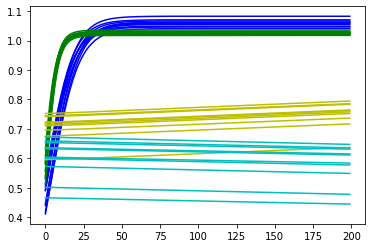

--------------------------------------------------------------------------
using cpu
epoch = 10000
epoch_step = 1000
model_name = SimpleNetworkAD
now_string = 2022-08-26-16-41-08
model_save_path_last = /content/drive/My Drive/PINN//train/SimpleNetworkAD_10000_1000_0.003_2022-08-26-16-41-08_last.pt
model_save_path_best = /content/drive/My Drive/PINN//train/SimpleNetworkAD_10000_1000_0.003_2022-08-26-16-41-08_best.pt
loss_save_path = /content/drive/My Drive/PINN//loss/SimpleNetworkAD_10000_1000_0.003_2022-08-26-16-41-08_loss_10000.npy
args = {'epoch': 10000, 'epoch_step': 1000, 'lr': 0.003, 'main_path': '/content/drive/My Drive/PINN/', 'save_step': 2000}
config = {'T_all': 10.0, 'T': 10.0, 'T_unit': 0.05, 'T_N': 200, 'N': 200, 'Node': 40, 'k_a': Parameter containing:
tensor([0.2934], requires_grad=True), 'k_ta': 0.08, 'k_mt': 0.718, 'd_a': 0.06, 'theta': 2, 'k_t': 5, 'k_at': 0.08, 'k_ma': 0.7, 'd_t': 0.06, 'delta': 2, 'k_tn': 0.03566, 'k_mtn': 0.08, 'gamma': 3, 'k_an': 0.05, 'k_man': 5.0

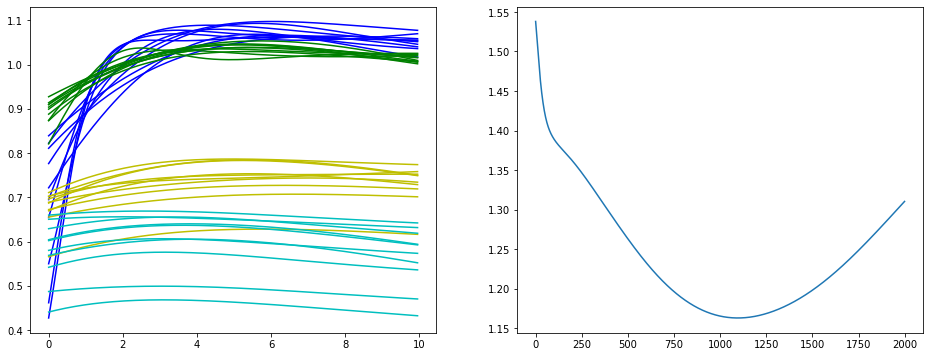

Epoch [03000/10000] Loss:0.698192 Loss_1:0.690789 Loss_2:0.007403 Loss_3:0.000000 Lr:0.002308 Time:82.298005s (4.09min in total, 9.55min remains)
True: 2.1; estimated:  1.5229989290237427
Epoch [04000/10000] Loss:0.447664 Loss_1:0.441285 Loss_2:0.006378 Loss_3:0.000000 Lr:0.002143 Time:82.053316s (5.46min in total, 8.19min remains)
True: 2.1; estimated:  1.6941540241241455
Testing & drawing...


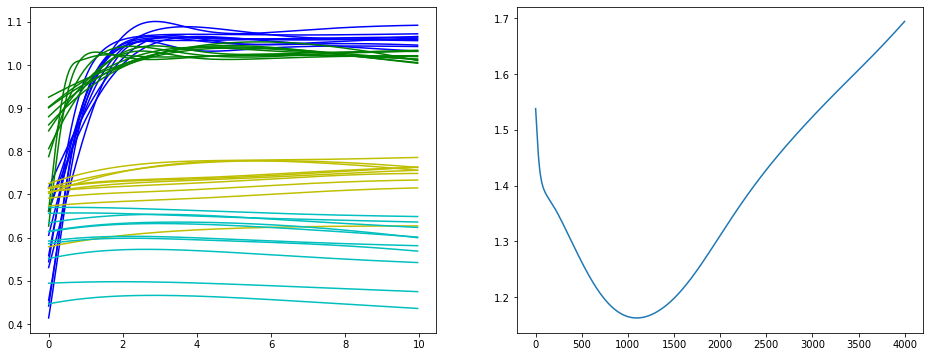

Epoch [05000/10000] Loss:0.292366 Loss_1:0.286887 Loss_2:0.005480 Loss_3:0.000000 Lr:0.002000 Time:81.073867s (6.81min in total, 6.81min remains)
True: 2.1; estimated:  1.8740501403808594
Epoch [06000/10000] Loss:0.204348 Loss_1:0.199817 Loss_2:0.004532 Loss_3:0.000000 Lr:0.001875 Time:82.065278s (8.18min in total, 5.45min remains)
True: 2.1; estimated:  1.9873120784759521
Testing & drawing...


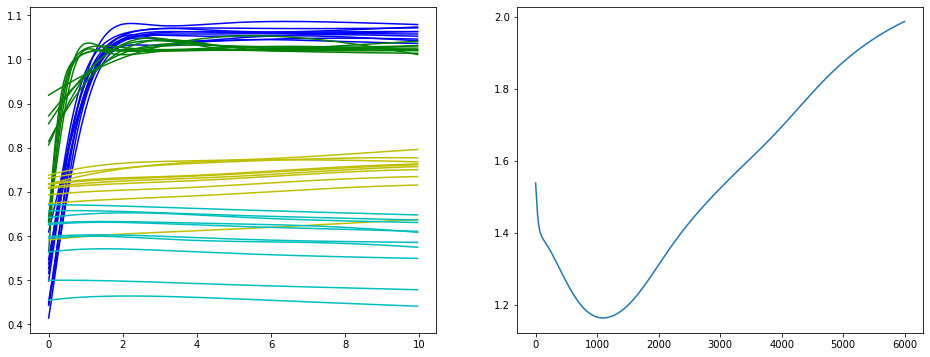

Epoch [07000/10000] Loss:0.142463 Loss_1:0.138459 Loss_2:0.004004 Loss_3:0.000000 Lr:0.001765 Time:80.916276s (9.53min in total, 4.08min remains)
True: 2.1; estimated:  2.0455992221832275
Epoch [08000/10000] Loss:0.088918 Loss_1:0.085582 Loss_2:0.003336 Loss_3:0.000000 Lr:0.001667 Time:82.244686s (10.90min in total, 2.73min remains)
True: 2.1; estimated:  2.073256492614746
Testing & drawing...


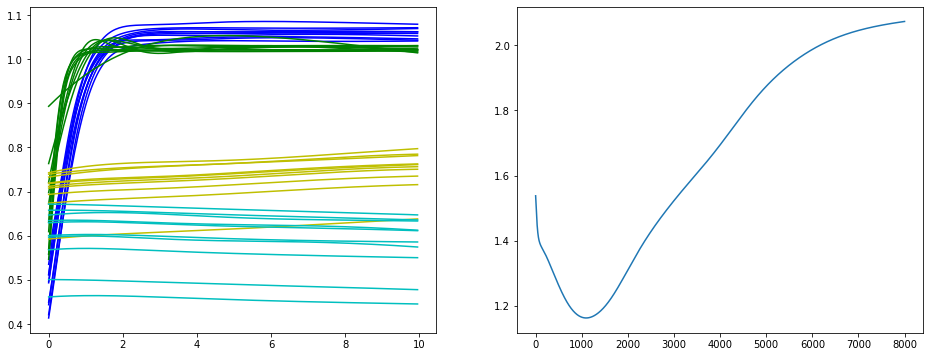

Epoch [09000/10000] Loss:0.040442 Loss_1:0.038043 Loss_2:0.002398 Loss_3:0.000000 Lr:0.001579 Time:80.794202s (12.25min in total, 1.36min remains)
True: 2.1; estimated:  2.0888350009918213
Epoch [10000/10000] Loss:0.011530 Loss_1:0.009853 Loss_2:0.001677 Loss_3:0.000000 Lr:0.001500 Time:81.753166s (13.61min in total, 0.00min remains)
True: 2.1; estimated:  2.0974817276000977
Testing & drawing...


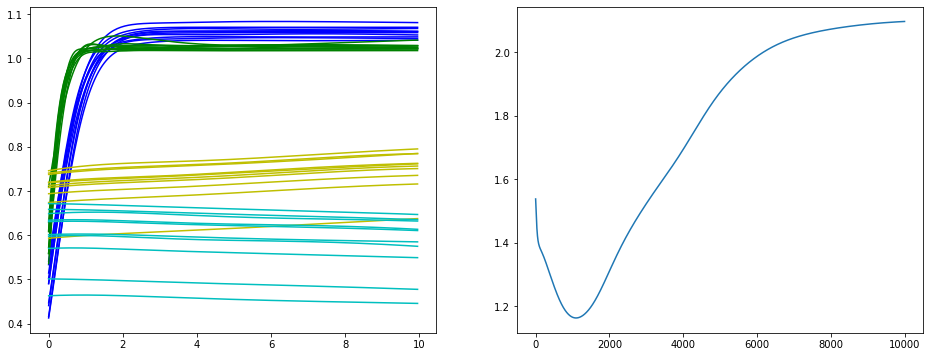

tensor board path: /content/drive/My Drive/PINN//board/SimpleNetworkAD_10000_1000_0.003_2022-08-26-16-41-08_board
%load_ext tensorboard
%tensorboard --logdir=/content/drive/My\ Drive/PINN//board/SimpleNetworkAD_10000_1000_0.003_2022-08-26-16-41-08_board
weight1: [0.2934289]
----------------------------truth-----------------------------------------
--------------------------------------------------------------------------


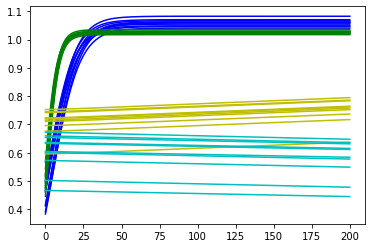

In [ ]:
################ truth rate = 1
mode1_1 = run_ad_truth(main_path)

self.truth_length: 20 of 200 all 
continue_id = None: [0, 10.0] is mapped to [40, 40]
----------------------------- ground truth ------------------------------------


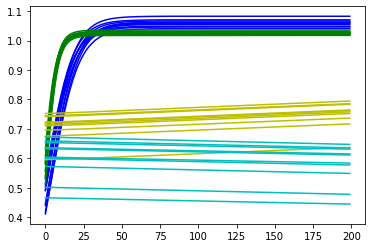

--------------------------------------------------------------------------
using cpu
epoch = 100000
epoch_step = 10000
model_name = SimpleNetworkAD
now_string = 2022-09-02-02-08-10
model_save_path_last = /content/drive/My Drive/PINN//train/SimpleNetworkAD_100000_10000_0.003_2022-09-02-02-08-10_last.pt
model_save_path_best = /content/drive/My Drive/PINN//train/SimpleNetworkAD_100000_10000_0.003_2022-09-02-02-08-10_best.pt
loss_save_path = /content/drive/My Drive/PINN//loss/SimpleNetworkAD_100000_10000_0.003_2022-09-02-02-08-10_loss_100000.npy
args = {'epoch': 100000, 'epoch_step': 10000, 'lr': 0.003, 'main_path': '/content/drive/My Drive/PINN/', 'save_step': 20000}
config = {'T_all': 10.0, 'T': 10.0, 'T_unit': 0.05, 'T_N': 200, 'N': 200, 'Node': 40, 'k_a': Parameter containing:
tensor([0.2957], requires_grad=True), 'k_ta': 0.08, 'k_mt': 0.718, 'd_a': 0.06, 'theta': 2, 'k_t': 5, 'k_at': 0.08, 'k_ma': 0.7, 'd_t': 0.06, 'delta': 2, 'k_tn': 0.03566, 'k_mtn': 0.08, 'gamma': 3, 'k_an': 0.05, 

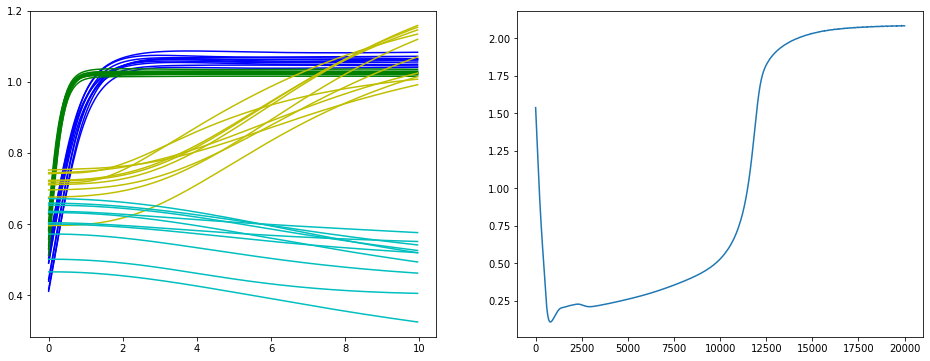

Epoch [30000/100000] Loss:0.000404 Loss_1:0.000142 Loss_2:0.000263 Loss_3:0.000000 Lr:0.000750 Time:698.765906s (35.29min in total, 82.34min remains)
True: 2.1; estimated:  2.0944321155548096
Epoch [40000/100000] Loss:0.000681 Loss_1:0.000472 Loss_2:0.000209 Loss_3:0.000000 Lr:0.000600 Time:694.400969s (46.86min in total, 70.29min remains)
True: 2.1; estimated:  2.098426103591919
Testing & drawing...


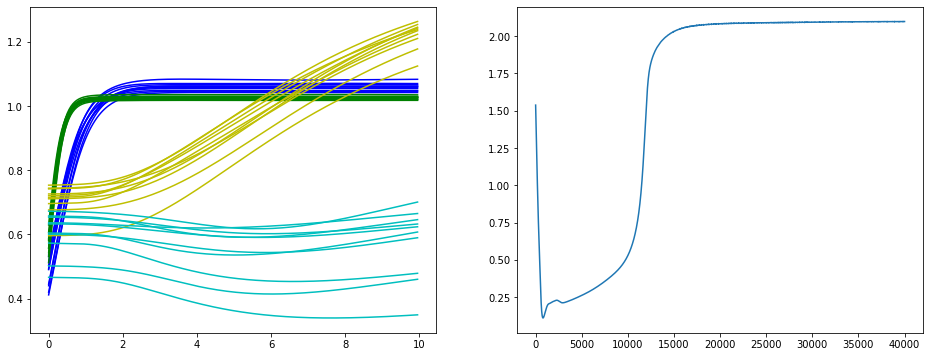

Epoch [50000/100000] Loss:0.000330 Loss_1:0.000149 Loss_2:0.000182 Loss_3:0.000000 Lr:0.000500 Time:689.385887s (58.35min in total, 58.35min remains)
True: 2.1; estimated:  2.0995166301727295
Epoch [60000/100000] Loss:0.000327 Loss_1:0.000168 Loss_2:0.000159 Loss_3:0.000000 Lr:0.000429 Time:692.867543s (69.90min in total, 46.60min remains)
True: 2.1; estimated:  2.0996601581573486
Testing & drawing...


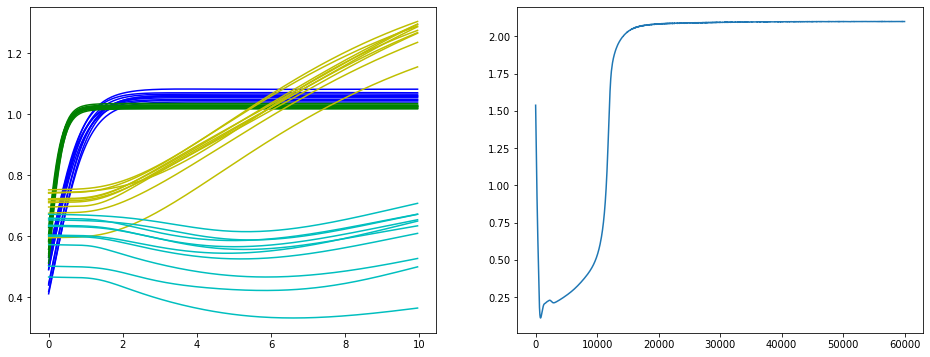

Epoch [70000/100000] Loss:0.000280 Loss_1:0.000134 Loss_2:0.000146 Loss_3:0.000000 Lr:0.000375 Time:693.368716s (81.45min in total, 34.91min remains)
True: 2.1; estimated:  2.099865436553955


In [ ]:
# truth rt = 0.1 
mode1_3 = run_ad_truth(main_path)

self.truth_length: 20 of 200 all 
continue_id = None: [0, 10.0] is mapped to [40, 40]
----------------------------- ground truth ------------------------------------


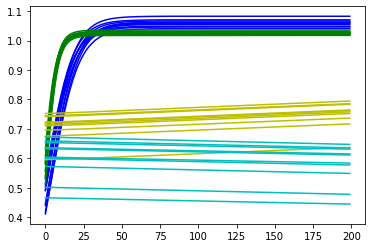

--------------------------------------------------------------------------
using cpu
epoch = 50000
epoch_step = 10000
model_name = SimpleNetworkAD
now_string = 2022-09-02-04-16-58
model_save_path_last = /content/drive/My Drive/PINN//train/SimpleNetworkAD_50000_10000_0.003_2022-09-02-04-16-58_last.pt
model_save_path_best = /content/drive/My Drive/PINN//train/SimpleNetworkAD_50000_10000_0.003_2022-09-02-04-16-58_best.pt
loss_save_path = /content/drive/My Drive/PINN//loss/SimpleNetworkAD_50000_10000_0.003_2022-09-02-04-16-58_loss_50000.npy
args = {'epoch': 50000, 'epoch_step': 10000, 'lr': 0.003, 'main_path': '/content/drive/My Drive/PINN/', 'save_step': 10000}
config = {'T_all': 10.0, 'T': 10.0, 'T_unit': 0.05, 'T_N': 200, 'N': 200, 'Node': 40, 'k_a': Parameter containing:
tensor([0.0935], requires_grad=True), 'k_ta': 0.08, 'k_mt': 0.718, 'd_a': 0.06, 'theta': 2, 'k_t': 5, 'k_at': 0.08, 'k_ma': 0.7, 'd_t': 0.06, 'delta': 2, 'k_tn': 0.03566, 'k_mtn': 0.08, 'gamma': 3, 'k_an': 0.05, 'k_man

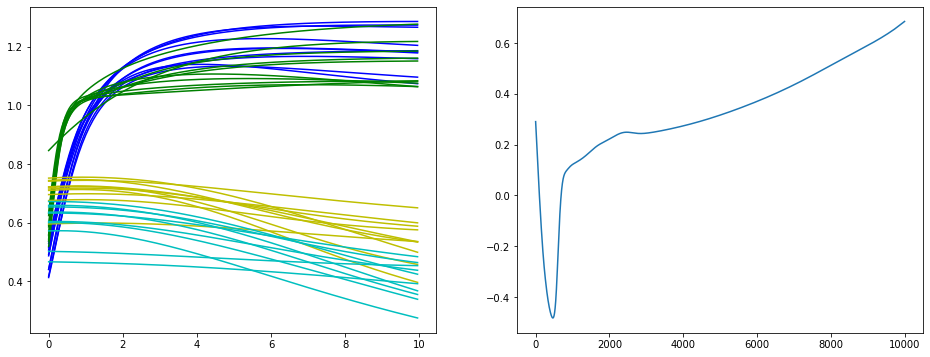

Epoch [20000/50000] Loss:0.004305 Loss_1:0.001092 Loss_2:0.003214 Loss_3:0.000000 Lr:0.001000 Time:789.717478s (27.22min in total, 40.83min remains)
True: 2.1; estimated:  2.0686259269714355
True: 5; estimated:  2.4935688972473145
True: 0.03566; estimated:  0.03116004914045334
True: 0.05; estimated:  2.2095017433166504
True: 0.03; estimated:  -0.05430716276168823
----------------------------
Testing & drawing...


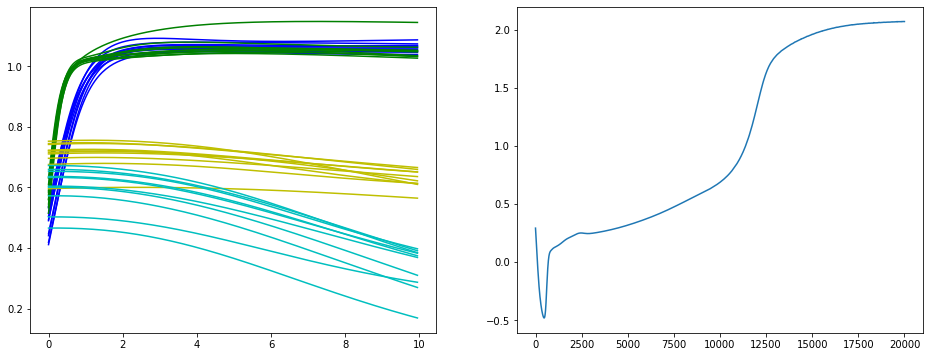

Epoch [30000/50000] Loss:0.000523 Loss_1:0.000464 Loss_2:0.000059 Loss_3:0.000000 Lr:0.000750 Time:785.011306s (40.30min in total, 26.87min remains)
True: 2.1; estimated:  2.0951333045959473
True: 5; estimated:  4.952785968780518
True: 0.03566; estimated:  -0.001247298321686685
True: 0.05; estimated:  -2.8516647815704346
True: 0.03; estimated:  0.021708479151129723
----------------------------
Testing & drawing...


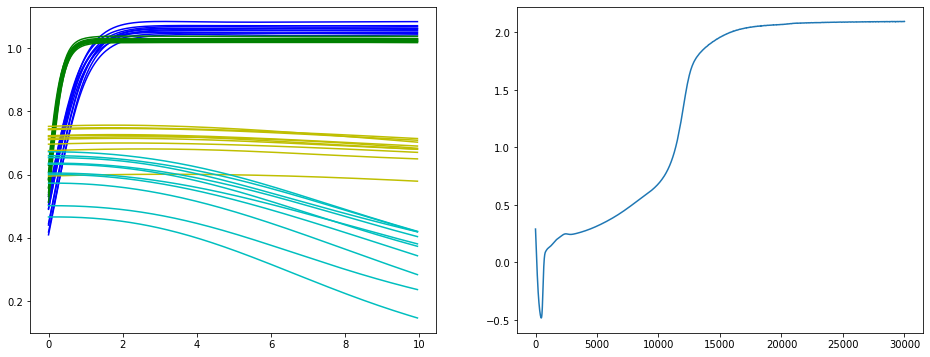

Epoch [40000/50000] Loss:0.000269 Loss_1:0.000220 Loss_2:0.000049 Loss_3:0.000000 Lr:0.000600 Time:788.900231s (53.45min in total, 13.36min remains)
True: 2.1; estimated:  2.097853183746338
True: 5; estimated:  4.95858097076416
True: 0.03566; estimated:  -0.002018432132899761
True: 0.05; estimated:  -2.3162269592285156
True: 0.03; estimated:  0.02016313746571541
----------------------------
Testing & drawing...


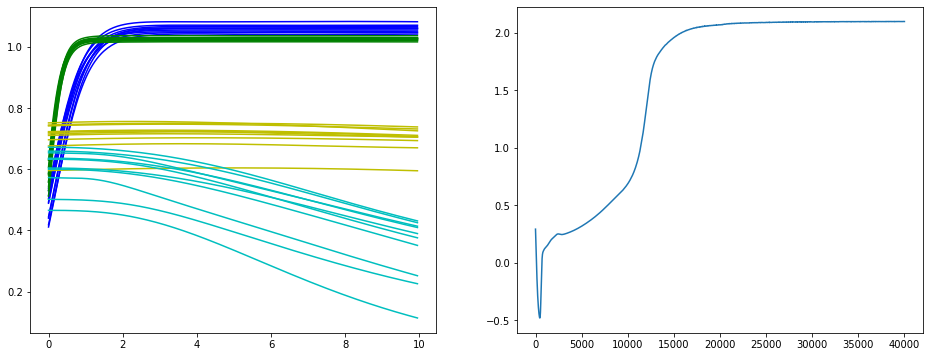

Epoch [50000/50000] Loss:0.000151 Loss_1:0.000111 Loss_2:0.000039 Loss_3:0.000000 Lr:0.000500 Time:790.891052s (66.63min in total, 0.00min remains)
True: 2.1; estimated:  2.0989327430725098
True: 5; estimated:  4.95888614654541
True: 0.03566; estimated:  -0.0010856186272576451
True: 0.05; estimated:  -1.6848762035369873
True: 0.03; estimated:  0.015477841719985008
----------------------------
Testing & drawing...


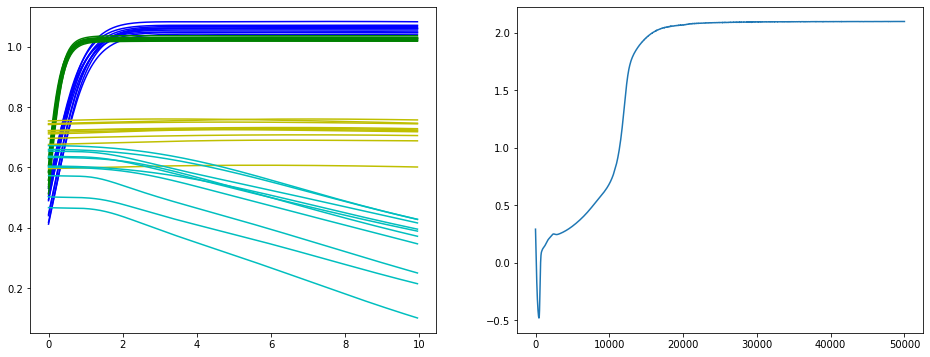

tensor board path: /content/drive/My Drive/PINN//board/SimpleNetworkAD_50000_10000_0.003_2022-09-02-04-16-58_board
%load_ext tensorboard
%tensorboard --logdir=/content/drive/My\ Drive/PINN//board/SimpleNetworkAD_50000_10000_0.003_2022-09-02-04-16-58_board
weight1: [0.09352756]
----------------------------truth-----------------------------------------
--------------------------------------------------------------------------


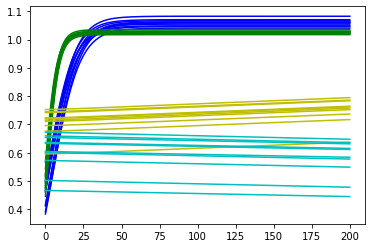

In [ ]:
# truth rt = 0.1; 5 parameters
mode1_4 = run_ad_truth(main_path)

self.truth_length: 200 of 200 all 
continue_id = None: [0, 10.0] is mapped to [40, 40]
----------------------------- ground truth ------------------------------------


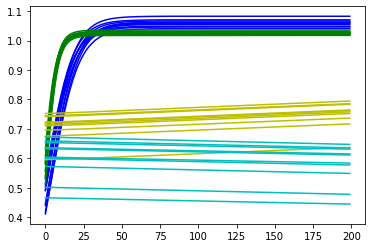

--------------------------------------------------------------------------
using cpu
epoch = 50000
epoch_step = 10000
model_name = SimpleNetworkAD
now_string = 2022-09-02-12-54-58
model_save_path_last = /content/drive/My Drive/PINN//train/SimpleNetworkAD_50000_10000_0.003_2022-09-02-12-54-58_last.pt
model_save_path_best = /content/drive/My Drive/PINN//train/SimpleNetworkAD_50000_10000_0.003_2022-09-02-12-54-58_best.pt
loss_save_path = /content/drive/My Drive/PINN//loss/SimpleNetworkAD_50000_10000_0.003_2022-09-02-12-54-58_loss_50000.npy
args = {'epoch': 50000, 'epoch_step': 10000, 'lr': 0.003, 'main_path': '/content/drive/My Drive/PINN/', 'save_step': 10000}
config = {'T_all': 10.0, 'T': 10.0, 'T_unit': 0.05, 'T_N': 200, 'N': 200, 'Node': 40, 'k_a': Parameter containing:
tensor([0.6893], requires_grad=True), 'k_ta': 0.08, 'k_mt': 0.718, 'd_a': 0.06, 'theta': 2, 'k_t': 5, 'k_at': 0.08, 'k_ma': 0.7, 'd_t': 0.06, 'delta': 2, 'k_tn': 0.03566, 'k_mtn': 0.08, 'gamma': 3, 'k_an': 0.05, 'k_man

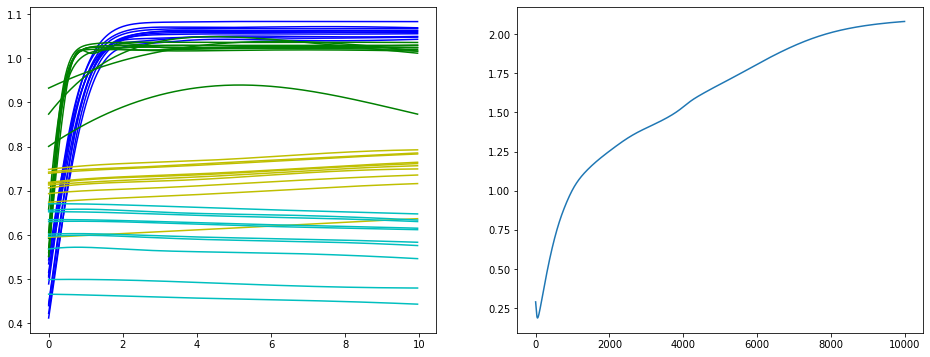

Epoch [20000/50000] Loss:0.052063 Loss_1:0.051205 Loss_2:0.000858 Loss_3:0.000000 Lr:0.001000 Time:924.591278s (31.07min in total, 46.61min remains)
True: 2.1; estimated:  2.10330867767334
True: 5; estimated:  4.63288688659668
True: 0.03566; estimated:  0.01669367402791977
True: 0.05; estimated:  2.373518943786621
True: 0.03; estimated:  -0.031553007662296295
----------------------------
Testing & drawing...


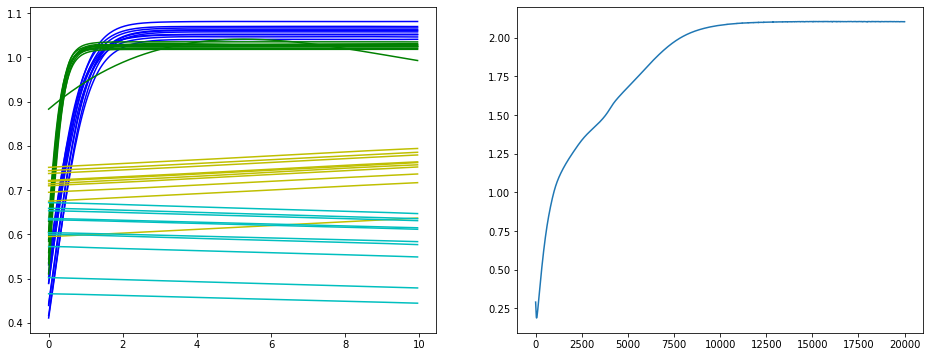

Epoch [30000/50000] Loss:0.000873 Loss_1:0.000662 Loss_2:0.000211 Loss_3:0.000000 Lr:0.000750 Time:960.752324s (47.08min in total, 31.39min remains)
True: 2.1; estimated:  2.1032841205596924
True: 5; estimated:  4.970852375030518
True: 0.03566; estimated:  0.005511553026735783
True: 0.05; estimated:  0.3815055787563324
True: 0.03; estimated:  -0.004298562649637461
----------------------------
Testing & drawing...


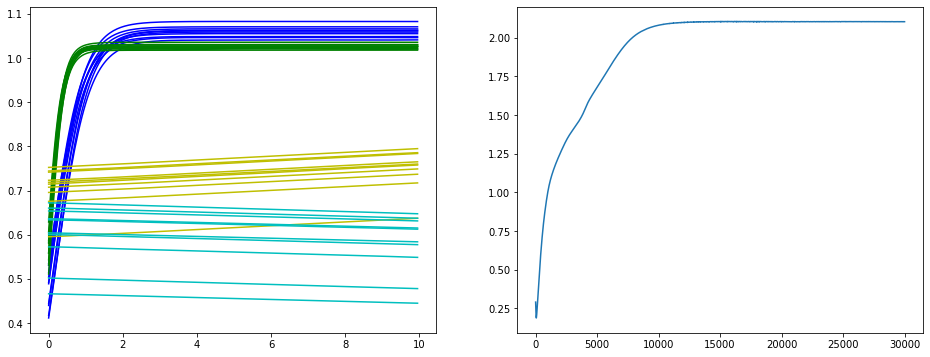

Epoch [40000/50000] Loss:0.000505 Loss_1:0.000296 Loss_2:0.000209 Loss_3:0.000000 Lr:0.000600 Time:950.502260s (62.93min in total, 15.73min remains)
True: 2.1; estimated:  2.10245680809021
True: 5; estimated:  4.983255386352539
True: 0.03566; estimated:  0.00458991713821888
True: 0.05; estimated:  0.3002612292766571
True: 0.03; estimated:  -0.002831190824508667
----------------------------
Testing & drawing...


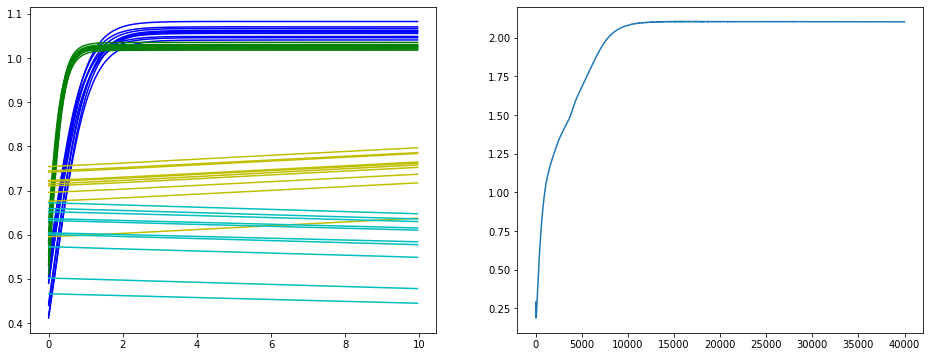

In [ ]:
# truth rt = 1; 5 parameters
mode1_4 = run_ad_truth(main_path)

self.truth_length: 200 of 200 all 
continue_id = None: [0, 10.0] is mapped to [40, 40]
----------------------------- ground truth ------------------------------------


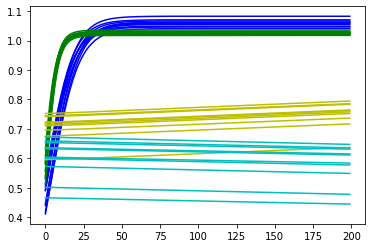

--------------------------------------------------------------------------
using cpu
epoch = 50000
epoch_step = 10000
model_name = SimpleNetworkAD
now_string = 2022-09-02-15-00-51
model_save_path_last = /content/drive/My Drive/PINN//train/SimpleNetworkAD_50000_10000_0.003_2022-09-02-15-00-51_last.pt
model_save_path_best = /content/drive/My Drive/PINN//train/SimpleNetworkAD_50000_10000_0.003_2022-09-02-15-00-51_best.pt
loss_save_path = /content/drive/My Drive/PINN//loss/SimpleNetworkAD_50000_10000_0.003_2022-09-02-15-00-51_loss_50000.npy
args = {'epoch': 50000, 'epoch_step': 10000, 'lr': 0.003, 'main_path': '/content/drive/My Drive/PINN/', 'save_step': 10000}
config = {'T_all': 10.0, 'T': 10.0, 'T_unit': 0.05, 'T_N': 200, 'N': 200, 'Node': 40, 'k_a': Parameter containing:
tensor([0.0935], requires_grad=True), 'k_ta': 0.08, 'k_mt': 0.718, 'd_a': 0.06, 'theta': 2, 'k_t': 5, 'k_at': 0.08, 'k_ma': 0.7, 'd_t': 0.06, 'delta': 2, 'k_tn': 0.03566, 'k_mtn': 0.08, 'gamma': 3, 'k_an': 0.05, 'k_man

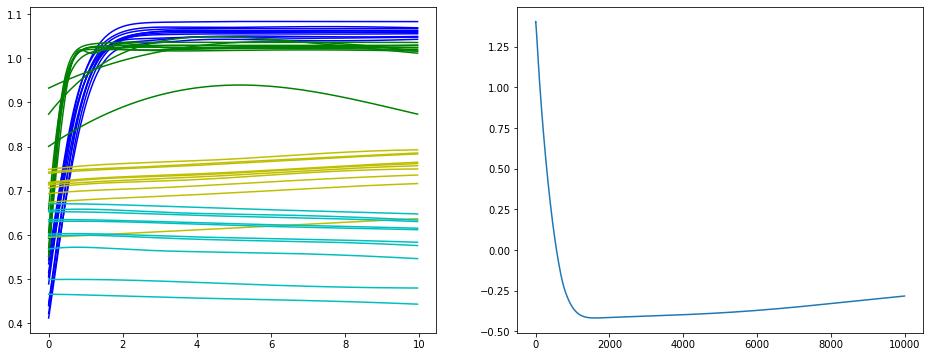

Epoch [20000/50000] Loss:0.052063 Loss_1:0.051205 Loss_2:0.000858 Loss_3:0.000000 Lr:0.001000 Time:948.354310s (32.17min in total, 48.26min remains)
True: 2.1; estimated:  2.10330867767334
True: 5; estimated:  4.63288688659668
True: 0.03566; estimated:  0.01669367402791977
True: 0.05; estimated:  2.373518943786621
True: 0.03; estimated:  -0.031553007662296295
----------------------------
Testing & drawing...


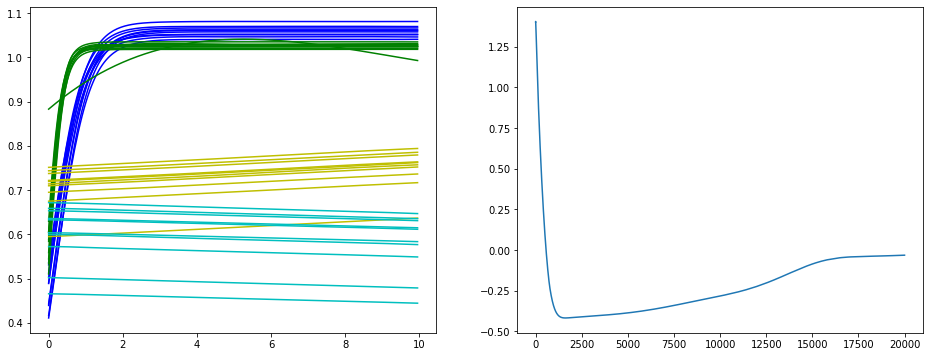

Epoch [30000/50000] Loss:0.000873 Loss_1:0.000662 Loss_2:0.000211 Loss_3:0.000000 Lr:0.000750 Time:948.626611s (47.98min in total, 31.99min remains)
True: 2.1; estimated:  2.1032841205596924
True: 5; estimated:  4.970852375030518
True: 0.03566; estimated:  0.005511553026735783
True: 0.05; estimated:  0.3815055787563324
True: 0.03; estimated:  -0.004298562649637461
----------------------------
Testing & drawing...


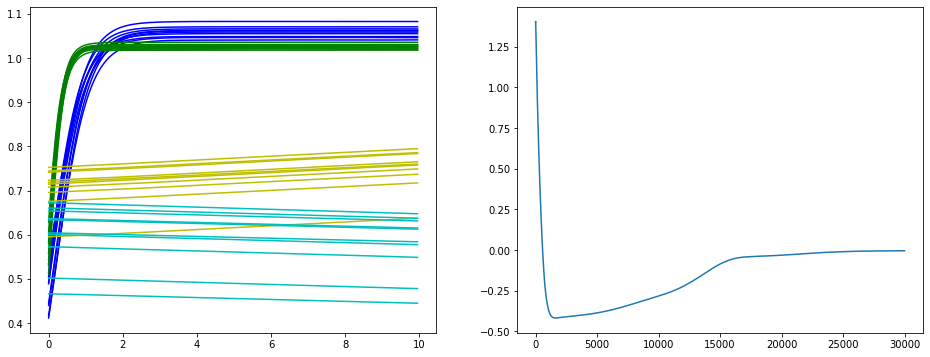

Epoch [40000/50000] Loss:0.000505 Loss_1:0.000296 Loss_2:0.000209 Loss_3:0.000000 Lr:0.000600 Time:962.865181s (64.03min in total, 16.01min remains)
True: 2.1; estimated:  2.10245680809021
True: 5; estimated:  4.983255386352539
True: 0.03566; estimated:  0.00458991713821888
True: 0.05; estimated:  0.3002612292766571
True: 0.03; estimated:  -0.002831190824508667
----------------------------
Testing & drawing...


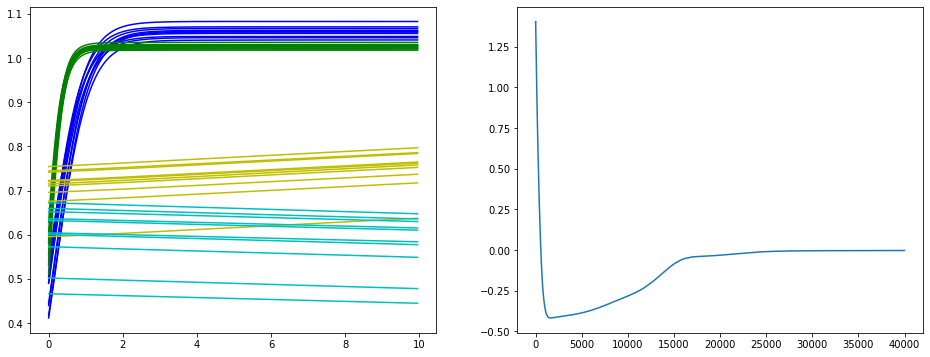

Epoch [50000/50000] Loss:0.000283 Loss_1:0.000075 Loss_2:0.000208 Loss_3:0.000000 Lr:0.000500 Time:944.523436s (79.77min in total, 0.00min remains)
True: 2.1; estimated:  2.102330207824707
True: 5; estimated:  4.975658416748047
True: 0.03566; estimated:  0.004286689218133688
True: 0.05; estimated:  0.2856103181838989
True: 0.03; estimated:  -0.0023172993678599596
----------------------------
Testing & drawing...


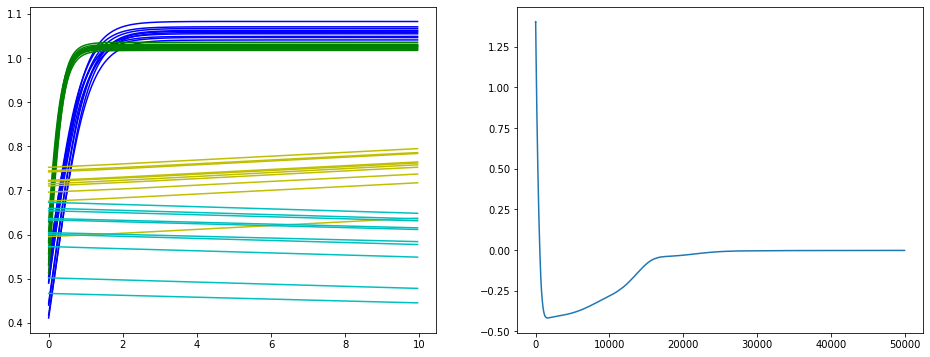

tensor board path: /content/drive/My Drive/PINN//board/SimpleNetworkAD_50000_10000_0.003_2022-09-02-15-00-51_board
%load_ext tensorboard
%tensorboard --logdir=/content/drive/My\ Drive/PINN//board/SimpleNetworkAD_50000_10000_0.003_2022-09-02-15-00-51_board
weight1: [0.09352756]
----------------------------truth-----------------------------------------
--------------------------------------------------------------------------


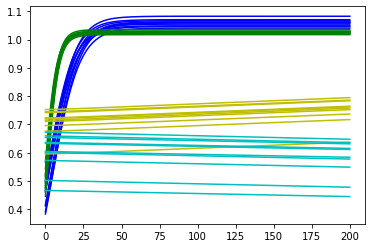

In [ ]:
# truth rt = 1; 5 parameters
mode1_5 = run_ad_truth(main_path)